# Project: To predict the sales of weather sensitive products of walmart 
------------------------------------------------------------------------------------------------------------------

## PHASE 2: EDA - Merging cleaned weather.csv,into train.csv, as per the train.csv 
------------------------------------------------------------------------------------------------------------------

### Author: Soumen Chatterjee
==================================================================================================================


#### The main goal here is - 

01. Import all the req libraries
02. Loading all the data files
03. Merging the 3 dataframes. train_cleaned is considered as Base daframe
04. Columns are rearranged
05. Setting date as index
06. Columns Standardization
07. Removing low variance features (threshold = 0.001)
08. Using Pearson Correlation - removing corelated features
09. Dropping constant & corelated features as part of dimension reduction
10. Checking distributions
11. Saving the data files for Modelling part

### Importing all the req. libraries

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


Loading up all the 3 data sets

In [ ]:
#Loading the data
from google.colab import drive
drive.mount('/content/drive')

df_train_cleaned = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/train_cleaned.csv")
df_weather_cleaned = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/weather_cleaned.csv")
df_key = pd.read_csv("/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/key.csv")
#df_weather_cleaned.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Merging the dataframes

In [ ]:
df_train_key = df_train_cleaned.merge(df_key, how='left', on='store_nbr')
df_train_key_weather = df_train_key.merge(df_weather_cleaned, how='left', on=['station_nbr','date'])

#Revewing the total count of rows are simlar or not and also is there any null values: Passed
#df_train_key_weather.info() 
#df_train_key_weather.head()


In [ ]:
rstructured_columnlist = ['date', 'store_nbr',	'item_nbr',	'station_nbr',	'tmax',	'tmin',	'tavg',	'depart',	'dewpoint',	'wetbulb',	'heat',	'cool',	'snowfall',	'preciptotal',	'stnpressure',	'sealevel',	'resultspeed',	'resultdir',	'avgspeed','Day', 'Month', 'Quarter', 'Holiday',	'codesum_BCFG',	'codesum_BLDU',	'codesum_BLSN',	'codesum_BR',	'codesum_DU',	'codesum_DZ',	'codesum_FG',	'codesum_FG+',	'codesum_FU',	'codesum_FZDZ',	'codesum_FZFG',	'codesum_FZRA',	'codesum_GR',	'codesum_GS',	'codesum_HZ',	'codesum_MIFG',	'codesum_PL',	'codesum_PRFG',	'codesum_RA',	'codesum_SG',	'codesum_SN',	'codesum_SQ',	'codesum_TS',	'codesum_TSRA',	'codesum_TSSN',	'codesum_UP',	'codesum_VCFG',	'codesum_VCTS',	'codesum_nan',	'units']
df_train_key_weather2 = df_train_key_weather.reindex(columns = rstructured_columnlist, copy=True)


In [ ]:
if 'date' in df_train_key_weather2: #Additional check to avoid error
    df_train_key_weather2["date"] = pd.to_datetime(df_train_key_weather2["date"])
    df_train_key_weather2.set_index('date',inplace=True)

df_train_key_weather2.head(2)

,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Day,Month,Quarter,Holiday,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,units
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,1,9,1,52.0,31.0,42.0,1.5,36.0,40.0,23.0,0.0,0.0,0.05,29.78,29.92,3.6,20.0,4.6,1,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
2012-01-01,1,28,1,52.0,31.0,42.0,1.5,36.0,40.0,23.0,0.0,0.0,0.05,29.78,29.92,3.6,20.0,4.6,1,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
df_train_key_weather2.tail(2)

,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,Day,Month,Quarter,Holiday,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,units
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-10-31,45,9,16,53.0,34.0,44.0,1.5,35.0,41.0,21.0,0.0,0.0,0.0,29.9,29.99,4.5,3.0,5.3,31,10,4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10
2014-10-31,45,26,16,53.0,34.0,44.0,1.5,35.0,41.0,21.0,0.0,0.0,0.0,29.9,29.99,4.5,3.0,5.3,31,10,4,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


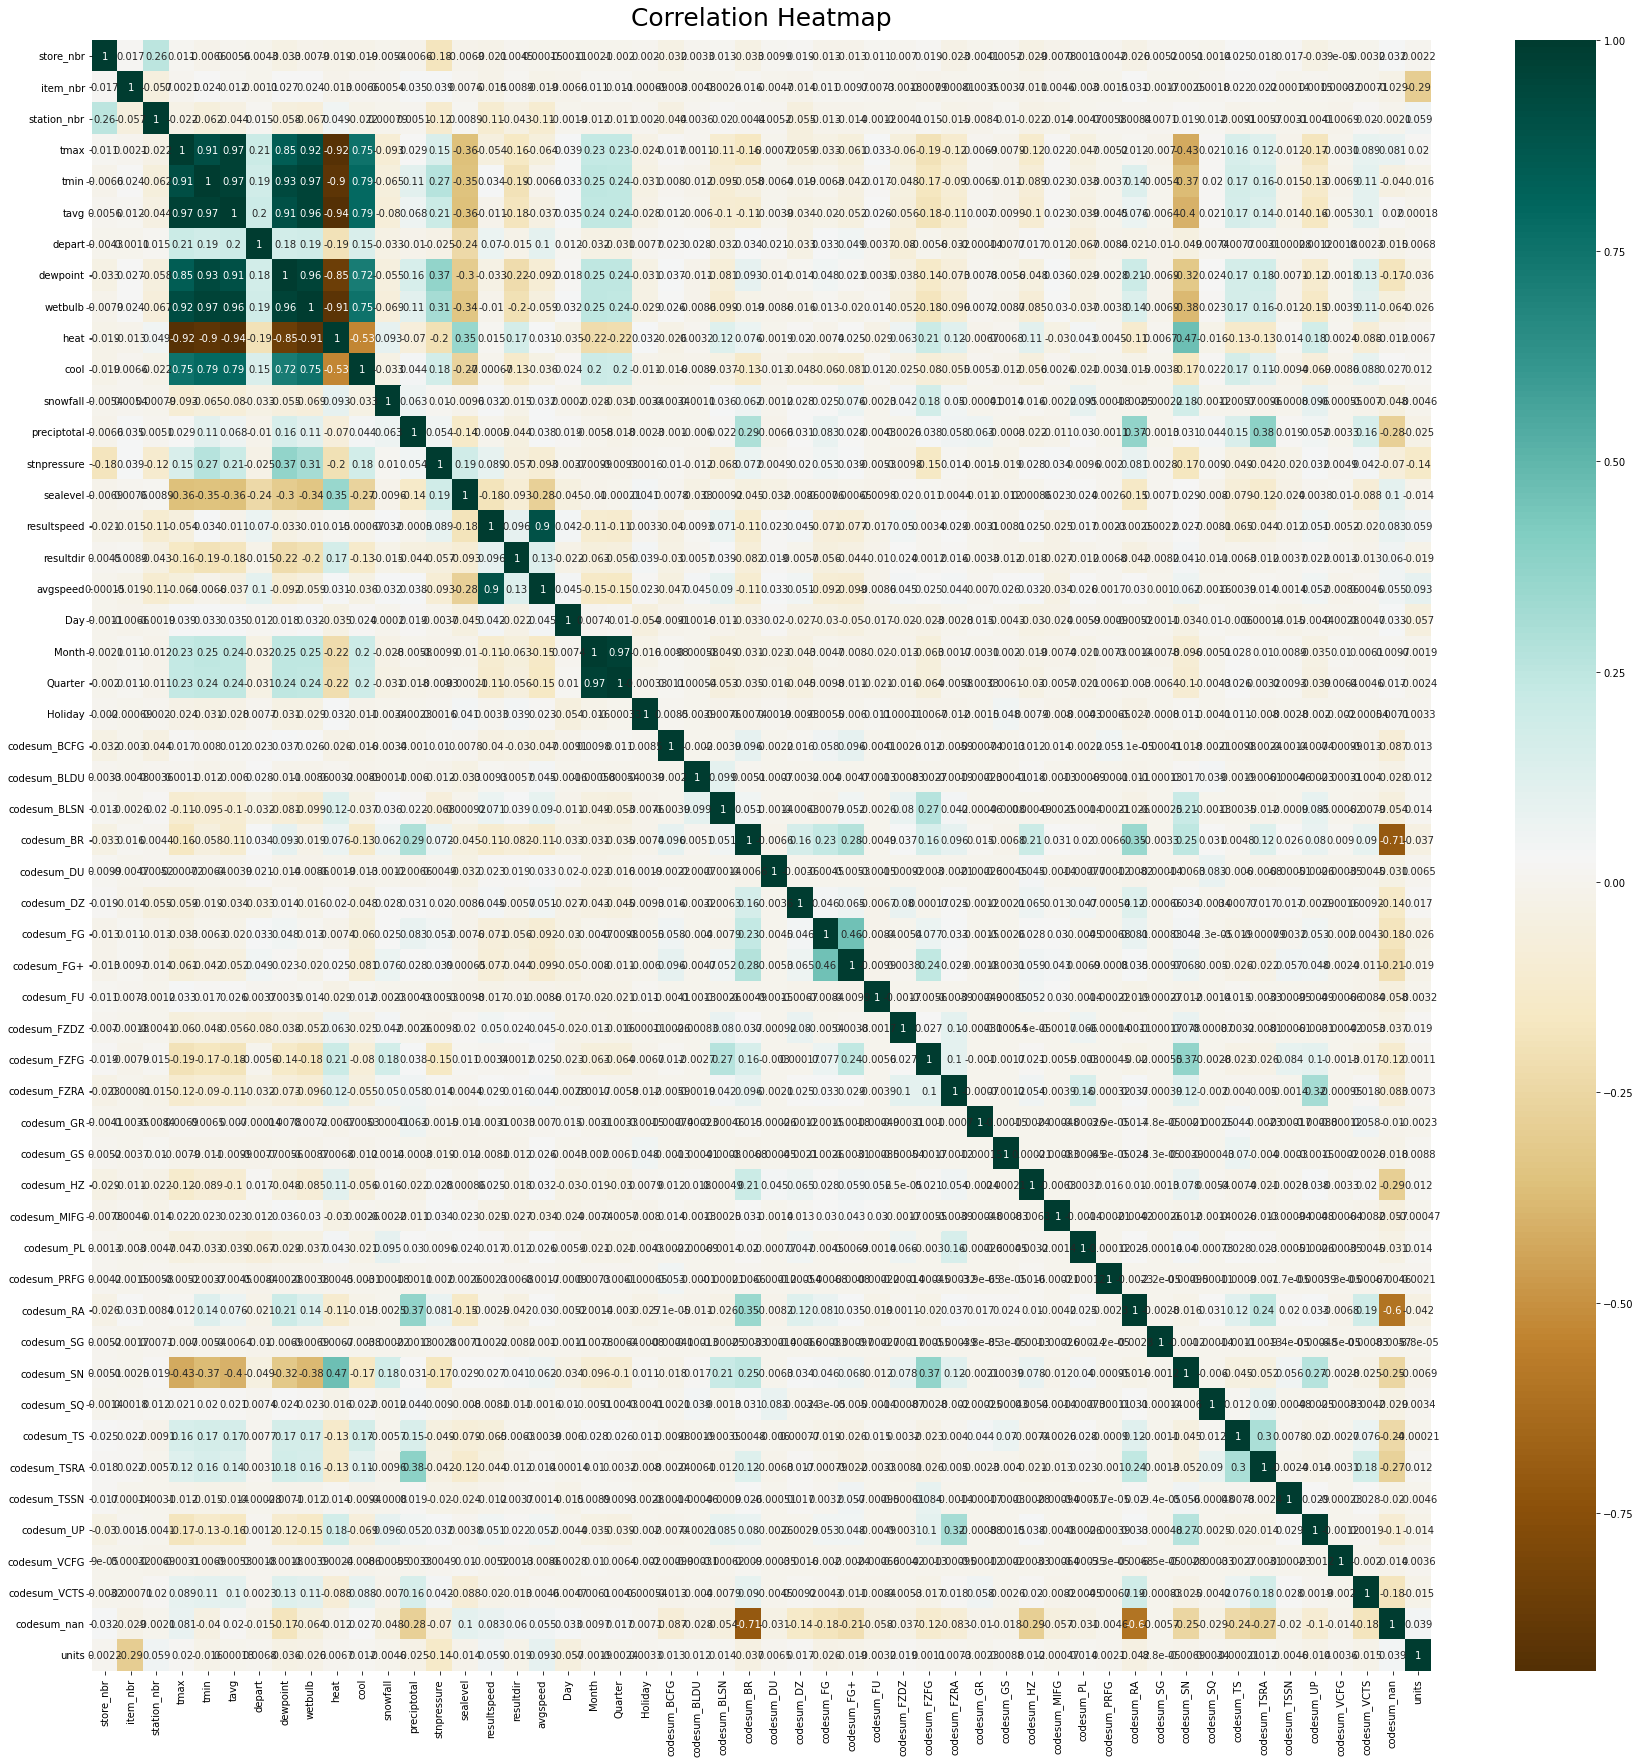

In [ ]:
import seaborn as sns
%matplotlib inline
#Using Pearson Correlation
plt.figure(figsize=(30, 30))
heatmap = sns.heatmap(df_train_key_weather2.corr(), annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':25}, pad=15);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


corr_features = correlation(df_train_key_weather2, 0.90)
len(set(corr_features))#6
corr_features



{'Quarter', 'dewpoint', 'heat', 'tavg', 'tmin', 'wetbulb'}

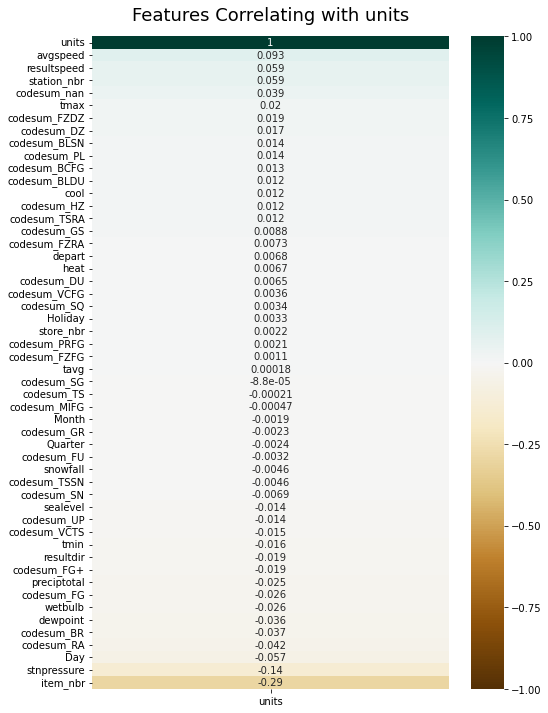

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_train_key_weather2.corr()[['units']].sort_values(by='units', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with units', fontdict={'fontsize':18}, pad=16);

Variance Threshold
Feature selector that removes all low-variance features.

This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.

In [ ]:
'''
The above features all have different medians, quartiles, and ranges — completely different distributions. We cannot compare these features to each other.
One method we can use is normalizing all features by dividing them by their mean:
'''
normalized_df = df_train_key_weather2 / df_train_key_weather2.mean()

from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0.003)
var_thres.fit(normalized_df)

VarianceThreshold(threshold=0.003)

In [ ]:
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
df_train_key_weather2.columns[var_thres.get_support()]
constant_columns = [column for column in df_train_key_weather2.columns
                    if column not in df_train_key_weather2.columns[var_thres.get_support()]]

print(len(constant_columns))

1


In [ ]:
constant_columns

['sealevel']

In [ ]:
remove_col = list(constant_columns) + list(corr_features)
#remove_col
df_Merged_cleand = df_train_key_weather2.drop(remove_col,axis=1)
df_Merged_cleand.head(5)
df_Merged_cleand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113709 entries, 2012-01-01 to 2014-10-31
Data columns (total 45 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     113709 non-null  int64  
 1   item_nbr      113709 non-null  int64  
 2   station_nbr   113709 non-null  int64  
 3   tmax          113709 non-null  float64
 4   depart        113709 non-null  float64
 5   cool          113709 non-null  float64
 6   snowfall      113709 non-null  float64
 7   preciptotal   113709 non-null  float64
 8   stnpressure   113709 non-null  float64
 9   resultspeed   113709 non-null  float64
 10  resultdir     113709 non-null  float64
 11  avgspeed      113709 non-null  float64
 12  Day           113709 non-null  int64  
 13  Month         113709 non-null  int64  
 14  Holiday       113709 non-null  bool   
 15  codesum_BCFG  113709 non-null  float64
 16  codesum_BLDU  113709 non-null  float64
 17  codesum_BLSN  113709 non-null  f

In [ ]:
df_Merged_cleand.head(2)

,store_nbr,item_nbr,station_nbr,tmax,depart,cool,snowfall,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,Day,Month,Holiday,codesum_BCFG,codesum_BLDU,codesum_BLSN,codesum_BR,codesum_DU,codesum_DZ,codesum_FG,codesum_FG+,codesum_FU,codesum_FZDZ,codesum_FZFG,codesum_FZRA,codesum_GR,codesum_GS,codesum_HZ,codesum_MIFG,codesum_PL,codesum_PRFG,codesum_RA,codesum_SG,codesum_SN,codesum_SQ,codesum_TS,codesum_TSRA,codesum_TSSN,codesum_UP,codesum_VCFG,codesum_VCTS,codesum_nan,units
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01,1,9,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
2012-01-01,1,28,1,52.0,1.5,0.0,0.0,0.05,29.78,3.6,20.0,4.6,1,1,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
len(df_Merged_cleand.columns)

45

<Figure size 1584x720 with 0 Axes>

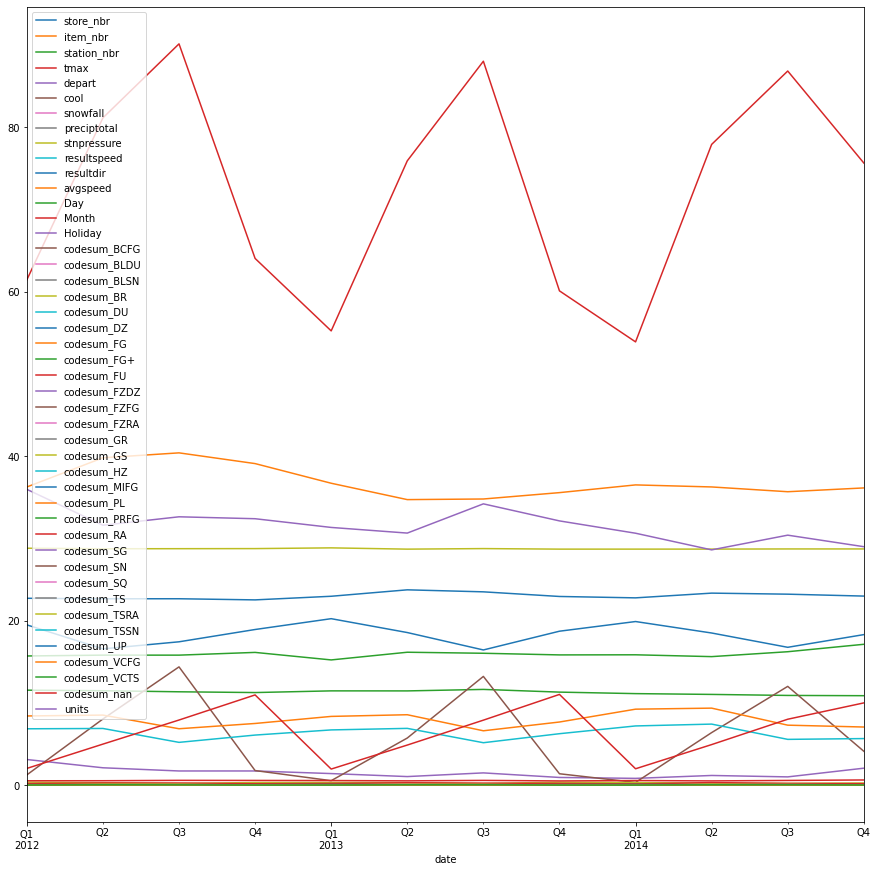

In [ ]:
plt.figure(figsize=(22,10))
temp_df_Merged = df_Merged_cleand.resample(rule='BQ').mean()
temp_df_Merged.plot(figsize=(15,15))

In [ ]:
#Restting the index for storing purpose
df_Merged_cleand.reset_index(inplace=True)
#df_Merged_cleand

In [ ]:
df_Merged_cleand.to_csv(r'/content/drive/MyDrive/Project_TS_Walmart/Phase 2/Data/df_Merged_cleand.csv', index=False)

As we more number of features pairplot here is not useful

In [ ]:
#sns.pairplot(df_Merged_cleand)
